In [1]:
pip install wordcloud

You should consider upgrading via the 'c:\users\intel\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import wordcloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Intel\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Intel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('fifa_world_cup_2022_tweets.csv')

In [4]:
df.head()

Unnamed: 0               Date Created  Number of Likes  \
0           0  2022-11-20 23:59:21+00:00                4   
1           1  2022-11-20 23:59:01+00:00                3   
2           2  2022-11-20 23:58:41+00:00                1   
3           3  2022-11-20 23:58:33+00:00                1   
4           4  2022-11-20 23:58:28+00:00                0   

       Source of Tweet                                              Tweet  \
0      Twitter Web App  What are we drinking today @TucanTribe \n@MadB...   
1   Twitter for iPhone  Amazing @CanadaSoccerEN  #WorldCup2022 launch ...   
2   Twitter for iPhone  Worth reading while watching #WorldCup2022 htt...   
3      Twitter Web App  Golden Maknae shinning bright\n\nhttps://t.co/...   
4  Twitter for Android  If the BBC cares so much about human rights, h...   

  Sentiment  
0   neutral  
1  positive  
2  positive  
3  positive  
4  negative

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22524 entries, 0 to 22523
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       22524 non-null  int64 
 1   Date Created     22524 non-null  object
 2   Number of Likes  22524 non-null  int64 
 3   Source of Tweet  22524 non-null  object
 4   Tweet            22524 non-null  object
 5   Sentiment        22524 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.0+ MB


In [6]:
df.columns

Index(['Unnamed: 0', 'Date Created', 'Number of Likes', 'Source of Tweet',
       'Tweet', 'Sentiment'],
      dtype='object')

In [7]:
df.isnull().sum()

Unnamed: 0         0
Date Created       0
Number of Likes    0
Source of Tweet    0
Tweet              0
Sentiment          0
dtype: int64

In [31]:
df['Sentiment'].value_counts()               #counts of sentiments

positive    8489
neutral     8251
negative    5784
Name: Sentiment, dtype: int64

In [32]:
100*df['Sentiment'].value_counts()/22524    #percentage of sentiments

positive    37.688688
neutral     36.632037
negative    25.679275
Name: Sentiment, dtype: float64

In [9]:
df.describe()

Unnamed: 0  Number of Likes
count  22524.000000     22524.000000
mean   11261.500000        23.822856
std     6502.263068      2128.018705
min        0.000000         0.000000
25%     5630.750000         0.000000
50%    11261.500000         0.000000
75%    16892.250000         2.000000
max    22523.000000    316867.000000

In [10]:
df['Number of Likes'].value_counts()

0       11627
1        4419
2        1889
3        1016
4         608
        ...  
86          1
945         1
379         1
1992        1
108         1
Name: Number of Likes, Length: 271, dtype: int64

In [11]:
text_df = df.drop(['Unnamed: 0', 'Date Created', 'Number of Likes', 'Source of Tweet','Sentiment'],axis=1)

In [12]:
text_df.head()

Tweet
0  What are we drinking today @TucanTribe \n@MadB...
1  Amazing @CanadaSoccerEN  #WorldCup2022 launch ...
2  Worth reading while watching #WorldCup2022 htt...
3  Golden Maknae shinning bright\n\nhttps://t.co/...
4  If the BBC cares so much about human rights, h...

In [13]:
print(text_df['Tweet'].iloc[0])
print(text_df['Tweet'].iloc[1])
print(text_df['Tweet'].iloc[2])
print(text_df['Tweet'].iloc[3])

What are we drinking today @TucanTribe 
@MadBears_ 
@lkinc_algo 
@al_goanna 

#WorldCup2022 https://t.co/Oga3TzvG5h
Amazing @CanadaSoccerEN  #WorldCup2022 launch video. Shows how much the face of Canada and our men’s national team have changed since our last World Cup entry in 1986.  Can’t wait to see these boys in action!

This is Canada: FIFA World Cup Opening Video https://t.co/7g73vvwtg8
Worth reading while watching #WorldCup2022 https://t.co/1SQrNa2dYU
Golden Maknae shinning bright

https://t.co/4AyZbzGTX4
#JeonJungkook #Jungkook #전정국 #정국 #JK #GoldenMaknae #bunny #Kookie #Jungshook #BTS #방탄소년단 #WorldCup2022 #FIFAKOOK 
@BTS_twt


In [14]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22524 entries, 0 to 22523
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   22524 non-null  object
dtypes: object(1)
memory usage: 176.1+ KB


# Data pre-processing

In [15]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [16]:
text_df['Tweet'] = text_df['Tweet'].apply(data_processing)

In [17]:
text_df = text_df.drop_duplicates('Tweet')

In [18]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [19]:
text_df['Tweet'] = text_df['Tweet'].apply(lambda x: stemming(x))

In [20]:
text_df.head()

Tweet
0  drinking today tucantribe madbears_ lkinc_algo...
1  amazing canadasocceren worldcup2022 launch vid...
2                worth reading watching worldcup2022
3  golden maknae shinning bright jeonjungkook jun...
4  bbc cares much human rights homosexual rights ...

In [21]:
print(text_df['Tweet'].iloc[0])
print(text_df['Tweet'].iloc[1])
print(text_df['Tweet'].iloc[2])
print(text_df['Tweet'].iloc[3])

drinking today tucantribe madbears_ lkinc_algo al_goanna worldcup2022
amazing canadasocceren worldcup2022 launch video shows much face canada mens national team changed since last world cup entry 1986 cant wait see boys action canada fifa world cup opening video
worth reading watching worldcup2022
golden maknae shinning bright jeonjungkook jungkook 전정국 정국 jk goldenmaknae bunny kookie jungshook bts 방탄소년단 worldcup2022 fifakook bts_twt


In [22]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21345 entries, 0 to 22523
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   21345 non-null  object
dtypes: object(1)
memory usage: 333.5+ KB


In [23]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [24]:
text_df['polarity'] = text_df['Tweet'].apply(polarity)

In [25]:
text_df.head(10)

Tweet  polarity
0  drinking today tucantribe madbears_ lkinc_algo...  0.000000
1  amazing canadasocceren worldcup2022 launch vid...  0.225000
2                worth reading watching worldcup2022  0.300000
3  golden maknae shinning bright jeonjungkook jun...  0.500000
4  bbc cares much human rights homosexual rights ...  0.000000
5  like mexican fans able scream puto homophobic ...  0.250000
6  look like jamaican football team naw follow wo...  0.000000
7  really football monday morning 9 12 3 need pin...  0.200000
8  world cup starts qatar black awareness day bra... -0.166667
9  worldcup2022 itvsport amp lfsystemmusic go tog...  0.500000

In [26]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [27]:
text_df['sentiment'] = text_df['polarity'].apply(sentiment)

In [28]:
text_df.head()

Tweet  polarity sentiment
0  drinking today tucantribe madbears_ lkinc_algo...     0.000   Neutral
1  amazing canadasocceren worldcup2022 launch vid...     0.225  Positive
2                worth reading watching worldcup2022     0.300  Positive
3  golden maknae shinning bright jeonjungkook jun...     0.500  Positive
4  bbc cares much human rights homosexual rights ...     0.000   Neutral

In [29]:
text_df['sentiment'].value_counts()      #count of sentiments

Positive    9127
Neutral     8786
Negative    3432
Name: sentiment, dtype: int64

In [33]:
100*text_df['sentiment'].value_counts()/21345    #percentage of sentiments

Positive    42.759428
Neutral     41.161865
Negative    16.078707
Name: sentiment, dtype: float64

# Data visualization

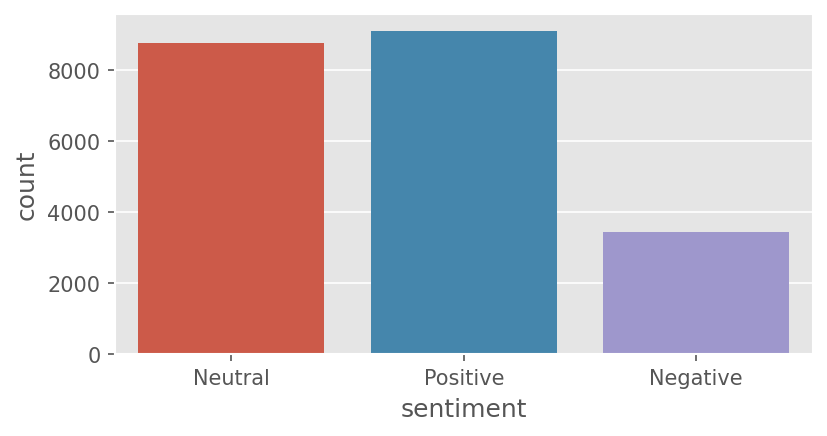

In [66]:
fig = plt.figure(figsize=(6,3),dpi=150)
sns.countplot(x='sentiment', data = text_df);
plt.savefig('count_sentiment.png',bbox_inches='tight')

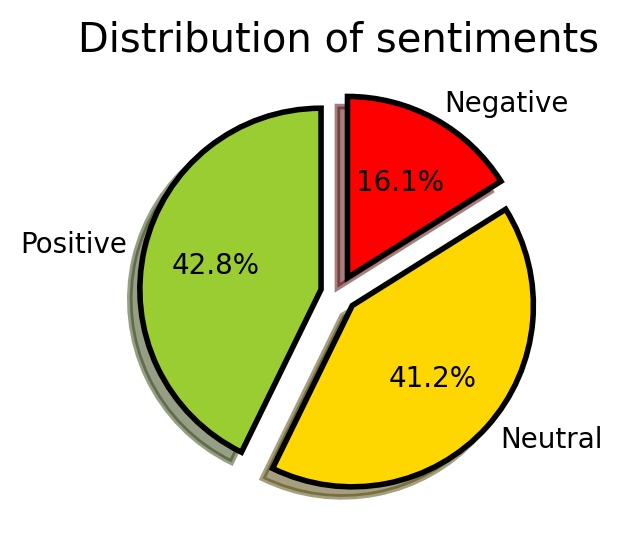

In [67]:
fig = plt.figure(figsize=(6,3),dpi=200)
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments');
plt.savefig('pie_chart_dist_of_sentiments.png',bbox_inches='tight')

In [41]:
pos_tweets = text_df[text_df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['polarity'], ascending= False)
pos_tweets.head()

Tweet  polarity sentiment
10604  fifa world cup go best luck teams fifaworldcup...       1.0  Positive
1814   five best websites working making money online...       1.0  Positive
22175  picture perfect one dance 2 worldcup2022 messi...       1.0  Positive
17867  another blow worldcup2022 one worlds best players       1.0  Positive
11799  qatar fifa foxsports im support usmnt im suppo...       1.0  Positive

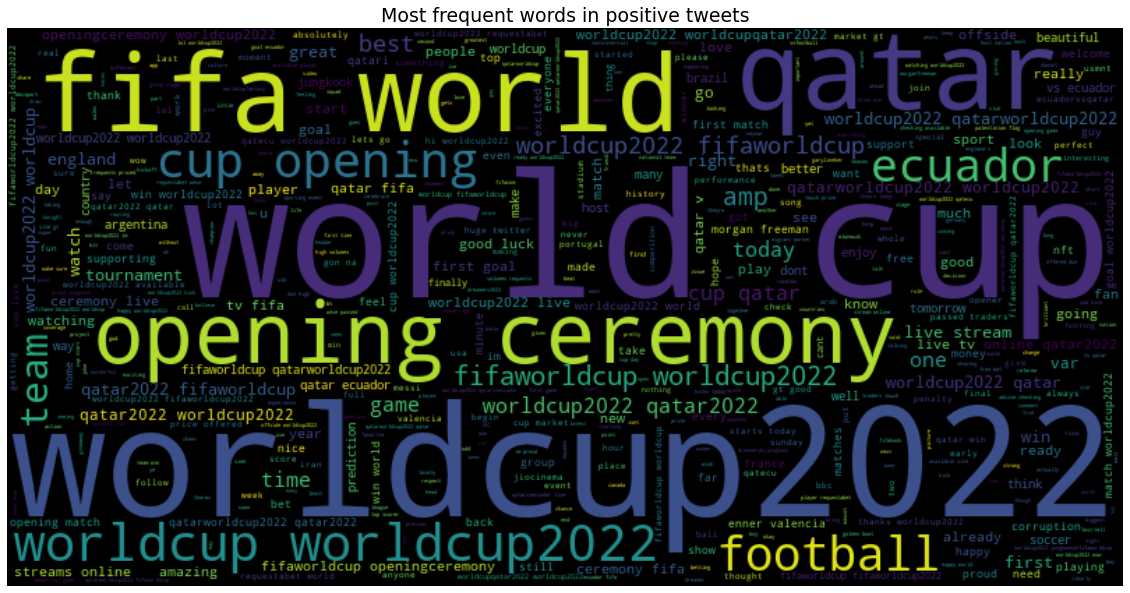

In [46]:
text = ' '.join([word for word in pos_tweets['Tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=800, height=400).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show();
wordcloud.to_file('wc_for_positive_tweet.png')

In [52]:
from PIL import Image

In [53]:
mask = np.array(Image.open('happy_emoji.png'))

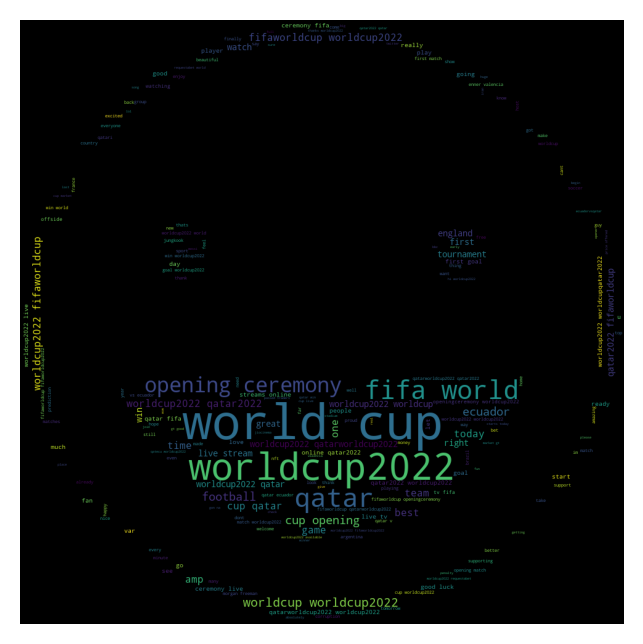

In [58]:
mwc = WordCloud(background_color='black',mask=mask, width=800, height=400)
mwc.generate(text)
plt.figure(figsize=(8,4),dpi=200, facecolor='white')
plt.imshow(mwc)
plt.axis('off')
plt.show()
mwc.to_file('mwc_for_positive_tweet.png')

In [59]:
neg_tweets = text_df[text_df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['polarity'], ascending= False)
neg_tweets.head()

Tweet      polarity  \
6148   fun fact host team 92 year history world cup l... -4.625929e-18   
12446  fun fact 92 year history world cup host never ... -9.251859e-18   
3237      exciting game far soccerpinnipeds worldcup2022 -9.251859e-18   
3641   qatar really playing today dont think shot goa... -1.387779e-17   
3417   qatar ecuator game see difference academy deve... -1.850372e-17   

      sentiment  
6148   Negative  
12446  Negative  
3237   Negative  
3641   Negative  
3417   Negative

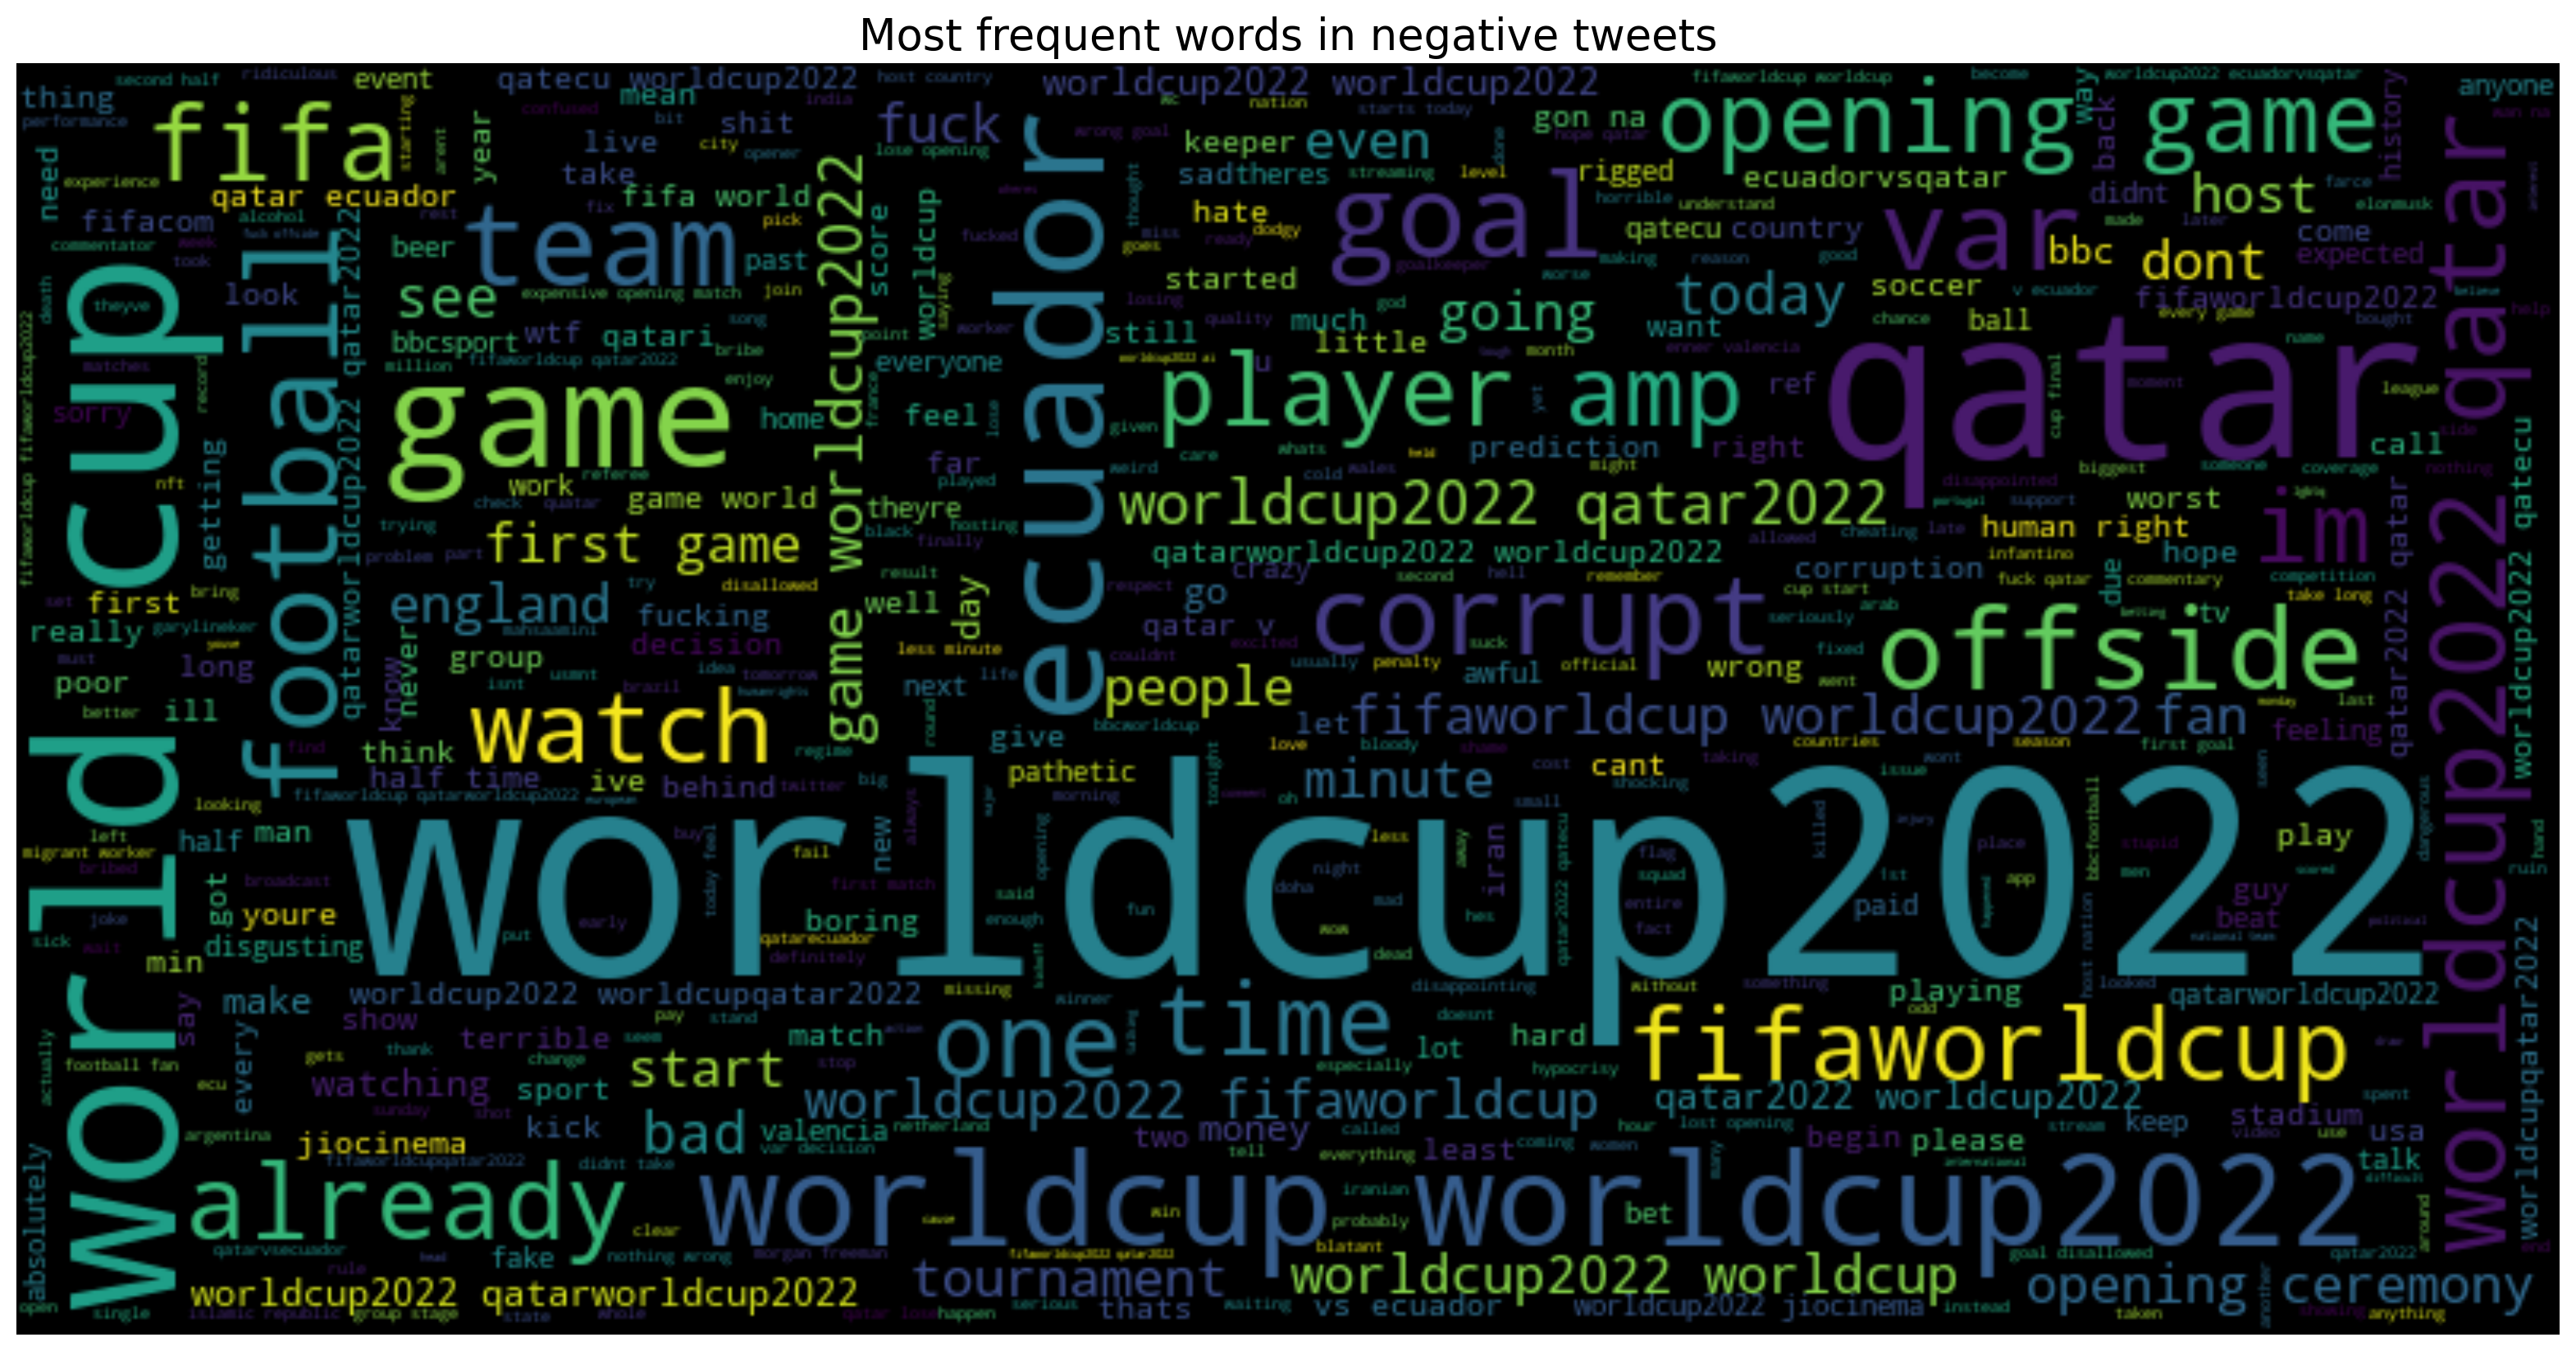

In [60]:
text = ' '.join([word for word in neg_tweets['Tweet']])
plt.figure(figsize=(20,15), facecolor='None',dpi=200)
wordcloud = WordCloud(max_words=500, width=800, height=400).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()
wordcloud.to_file('wc_for_negative_tweet.png');

In [63]:
mask2 = np.array(Image.open('angry_emoji.png'))

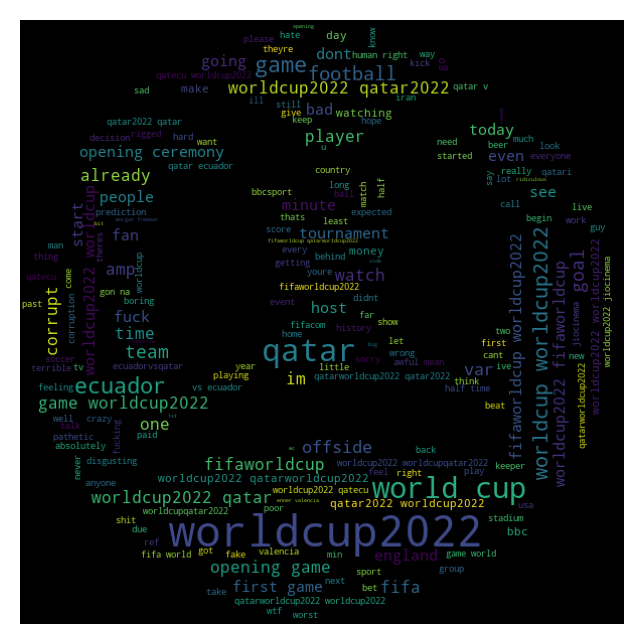

In [65]:
mwc2 = WordCloud(background_color='black',mask=mask2, width=800, height=400)
mwc2.generate(text)
plt.figure(figsize=(8,4),dpi=200, facecolor='white')
plt.imshow(mwc2)
plt.axis('off')
plt.show()
mwc2.to_file('mwc_for_negative_tweet.png')

In [68]:
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['polarity'], ascending= False)
neutral_tweets.head()

Tweet  polarity sentiment
0      drinking today tucantribe madbears_ lkinc_algo...       0.0   Neutral
14656                             1 hour go worldcup2022       0.0   Neutral
14643  thefootballverse worlds2022 worldcup2022 nike ...       0.0   Neutral
14644  yoongi hyungs always matter dreamers2022 jungk...       0.0   Neutral
14645      oh morgan mate involved shitshow worldcup2022       0.0   Neutral

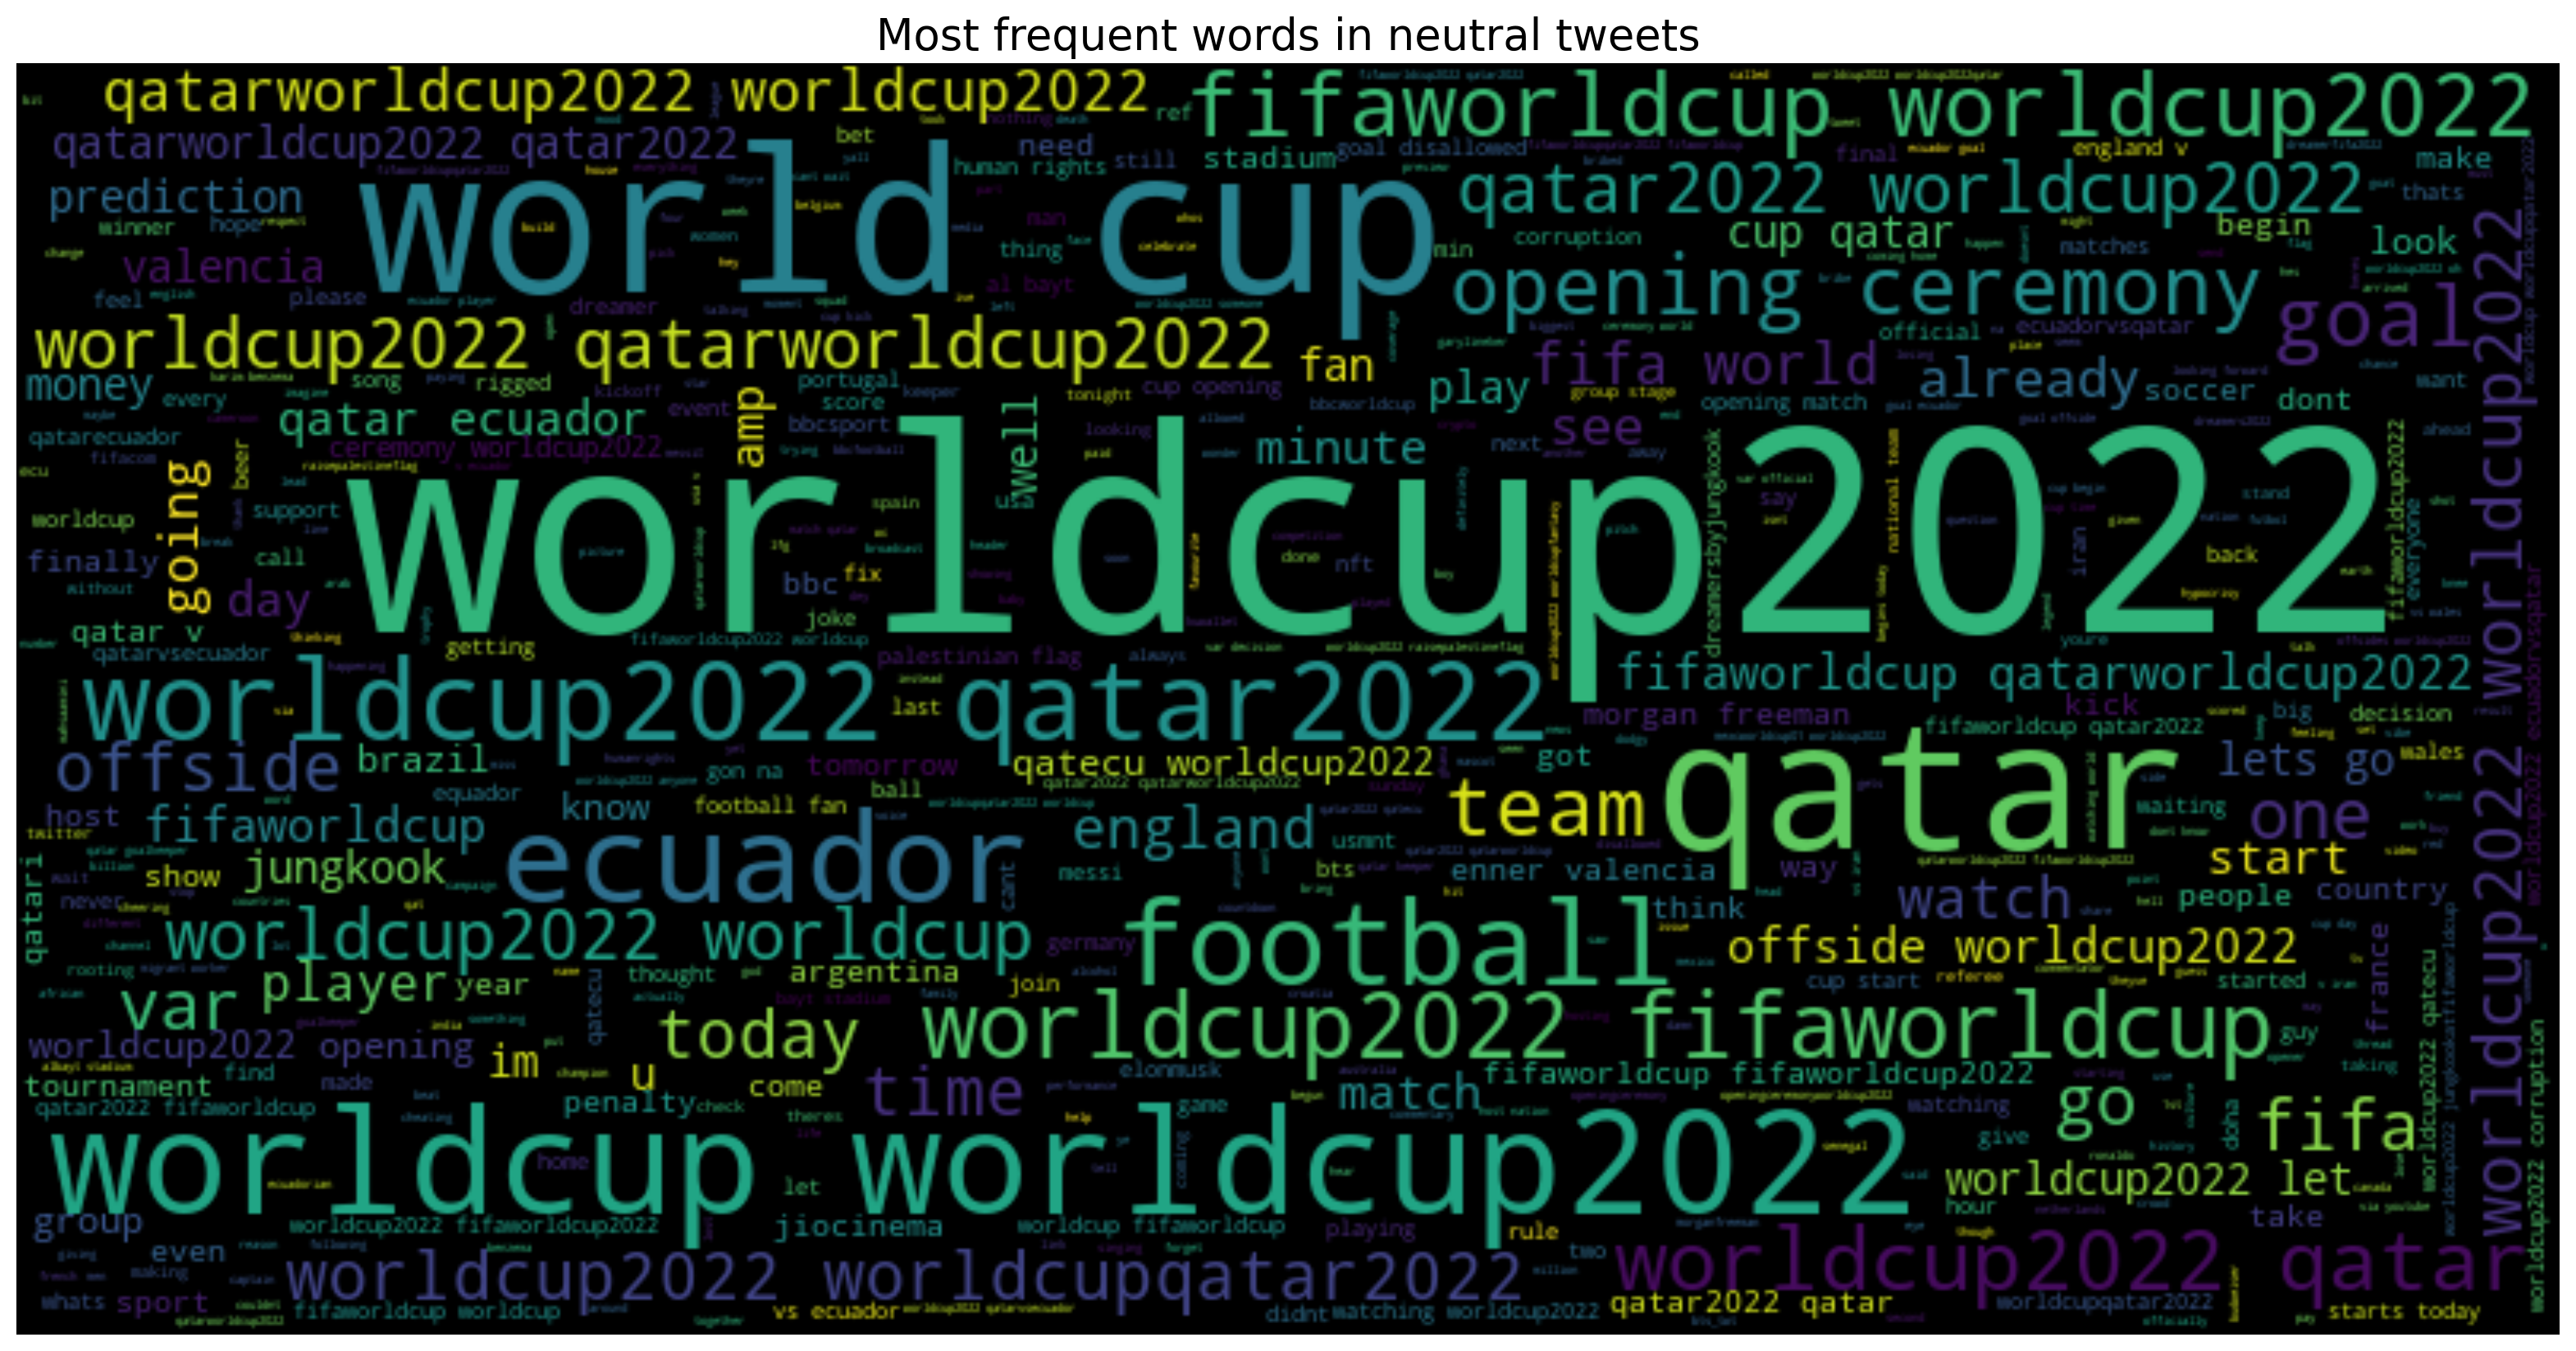

In [89]:
text = ' '.join([word for word in neutral_tweets['Tweet']])
plt.figure(figsize=(20,15),dpi=200,facecolor='None')
wordcloud = WordCloud(max_words=500, width=800, height=400).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()
wordcloud.to_file('wc_for_neutral_tweet.png');

In [95]:
mask3 = np.array(Image.open('neutral_emoji.png'))

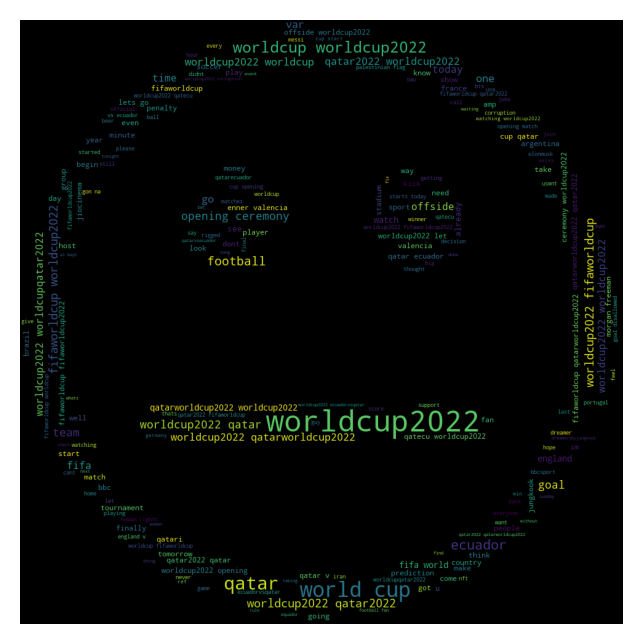

In [96]:
mwc3 = WordCloud(background_color='black',mask=mask3, width=800, height=400)
mwc3.generate(text)
plt.figure(figsize=(8,4),dpi=200, facecolor='None')
plt.imshow(mwc3)
plt.axis('off')
plt.show()
mwc3.to_file('mwc_for_neutral_tweet.png')

In [97]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['Tweet'])

In [99]:
feature_names = vect.get_feature_names_out()
print(f"Number of features: {len(feature_names)}\n")
print(f"First 20 features:\n {feature_names[:20]}")

Number of features: 160202

First 20 features:
 ['00' '00 10' '00 draw' '00 ecuador' '00 fifaworldcup' '00 game' '00 goes'
 '00 huge' '00 isnt' '00 prediction' '00 qatarworldcup2022' '00 saying'
 '00 worldcup2022' '000' '000 worldcup2022' '001' '001 43' '0014'
 '0014 lunaskynft' '002']


#  building the model using Logistic Regression

In [100]:
X = text_df['Tweet']
Y = text_df['sentiment']
X = vect.transform(X)

In [101]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [102]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (17076, 160202)
Size of y_train: (17076,)
Size of x_test: (4269, 160202)
Size of y_test: (4269,)


In [103]:
import warnings
warnings.filterwarnings('ignore')

In [104]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 89.72%


In [105]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[ 455  139   73]
 [  12 1743   16]
 [  40  159 1632]]


              precision    recall  f1-score   support

    Negative       0.90      0.68      0.78       667
     Neutral       0.85      0.98      0.91      1771
    Positive       0.95      0.89      0.92      1831

    accuracy                           0.90      4269
   macro avg       0.90      0.85      0.87      4269
weighted avg       0.90      0.90      0.89      4269



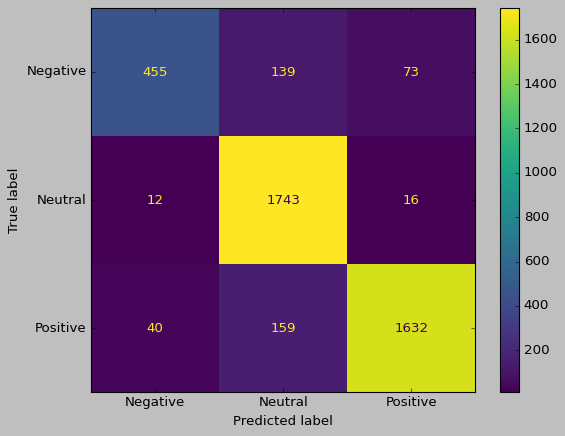

In [109]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

#  Hyperparameter Tuning

In [110]:
from sklearn.model_selection import GridSearchCV

In [111]:
param_grid={'C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [112]:
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 10}


In [113]:
y_pred = grid.predict(x_test)

In [114]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 91.38%


In [115]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[ 493  108   66]
 [  12 1745   14]
 [  40  128 1663]]


              precision    recall  f1-score   support

    Negative       0.90      0.74      0.81       667
     Neutral       0.88      0.99      0.93      1771
    Positive       0.95      0.91      0.93      1831

    accuracy                           0.91      4269
   macro avg       0.91      0.88      0.89      4269
weighted avg       0.92      0.91      0.91      4269



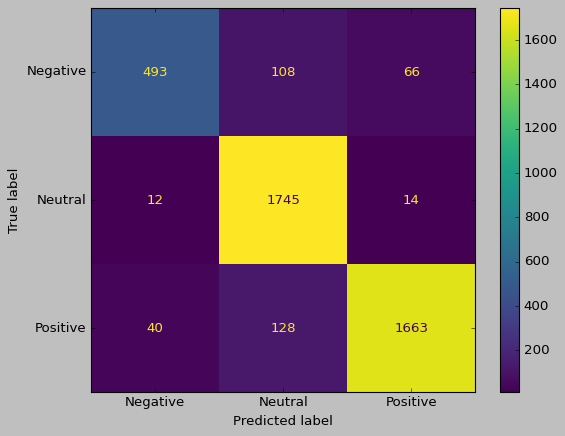

In [116]:
style.use('classic')
cm = confusion_matrix(y_test, y_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

# Using another algorithm (Support vector machine)

In [117]:
from sklearn.svm import LinearSVC

In [118]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)

LinearSVC()

In [119]:
svc_pred = SVCmodel.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("test accuracy: {:.2f}%".format(svc_acc*100))

test accuracy: 92.48%


In [120]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[ 514   86   67]
 [  12 1749   10]
 [  41  105 1685]]


              precision    recall  f1-score   support

    Negative       0.91      0.77      0.83       667
     Neutral       0.90      0.99      0.94      1771
    Positive       0.96      0.92      0.94      1831

    accuracy                           0.92      4269
   macro avg       0.92      0.89      0.90      4269
weighted avg       0.93      0.92      0.92      4269



# Hyperparameter Tuning for SVM

In [121]:
grid = {
    'C':[0.01, 0.1, 1, 10],
    'kernel':["linear","poly","rbf","sigmoid"],
    'degree':[1,3,5,7],
    'gamma':[0.01,1]
}
grid = GridSearchCV(SVCmodel, param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [122]:
print("Best parameter:", grid.best_params_)

Best parameter: {'C': 10}


In [123]:
y_pred = grid.predict(x_test)

In [124]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 92.60%


In [125]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[ 518   82   67]
 [  11 1751    9]
 [  42  105 1684]]


              precision    recall  f1-score   support

    Negative       0.91      0.78      0.84       667
     Neutral       0.90      0.99      0.94      1771
    Positive       0.96      0.92      0.94      1831

    accuracy                           0.93      4269
   macro avg       0.92      0.90      0.91      4269
weighted avg       0.93      0.93      0.92      4269



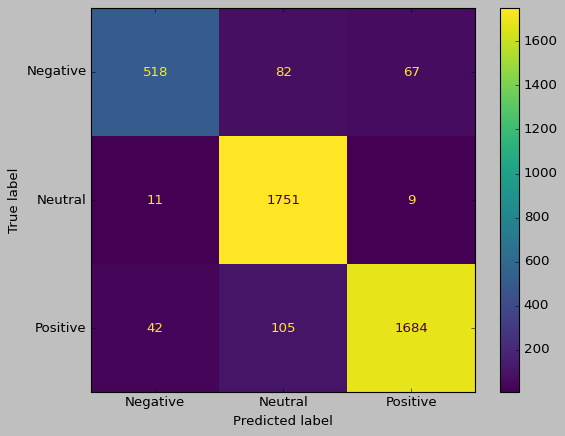

In [126]:
style.use('classic')
cm = confusion_matrix(y_test, y_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

In [189]:
# model = ['Logistic Regression','Tuned Logistic Regression','SVC','Tuned SVC']
# Accuracy = [89.72,91.38,92.48,92.60]
data = [['Logistic Reg', 89.72], ['Tuned Logistic Reg', 91.38], ['SVC', 92.48],['Tuned SVC', 92.60]]

In [190]:
relation_df = pd.DataFrame(data=data,columns=['model','Accuracy'])

In [191]:
relation_df

model  Accuracy
0        Logistic Reg     89.72
1  Tuned Logistic Reg     91.38
2                 SVC     92.48
3           Tuned SVC     92.60

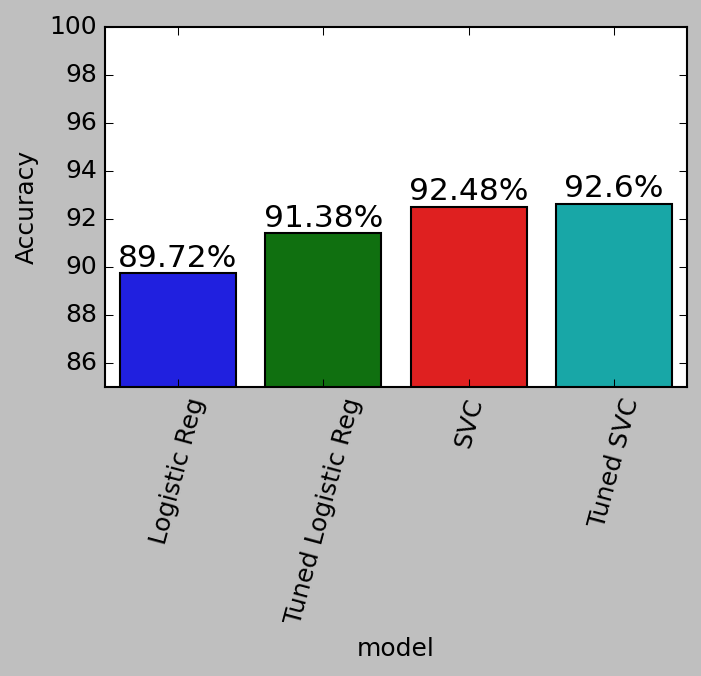

In [196]:
fig = plt.figure(figsize=(5,3),dpi=150)
sns.barplot(data=relation_df,x='model',y='Accuracy')
plt.xticks(rotation =75);
plt.ylim(85,100)
percentage = [89.72,91.38,92.48,92.60]
for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=15)
plt.show()
fig.savefig('barplot_of_percent_wise_accuracy.png',bbox_inches='tight')